# Python notebook for analyzing and finding peaks in CSV file data
Assumes folder directory structure:
<pre><code>  IMAGING
    image_stacks
    notebooks
    results
</code></pre>
NOTE: Looks for data files in the results directory.<br>
Execute the code sequentially, one block at a time, using &lt;shift-return&gt;.

# Package Import

In [54]:
from __future__ import print_function
import csv
import datetime
import glob
import os
from ipywidgets import interact, Layout
import ipywidgets as widgets
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from scipy import signal
from scipy.optimize import curve_fit, OptimizeWarning
import math
import warnings
# global variables
if os.name == "nt":
    FILE_SEP = "\\"
else:
    FILE_SEP = "/"


# Select data files for analysis

In [70]:
# Create widget for selecting CSV files for analysis
file_names = []
for file in sorted([f.split(FILE_SEP)[-1] for f in glob.glob("../results/*", recursive=False)], key=str.casefold):
    file_names.append(file[:-8]) # Remove "Results" from end of file names
data_files_widget = widgets.SelectMultiple(options=file_names, description = 'Data Files',
                                          disabled=False, layout={'width':'400px'}, style={'description_width':'100px'})
display(data_files_widget)

SelectMultiple(description='Data Files', layout=Layout(width='400px'), options=('GSK Experiment 1', 'GSK Exper…

# Create a new time-stamped results directory

In [71]:
results_dirs = []
data_files = []
selected_files = data_files_widget.value
for file in selected_files:
    if not os.path.exists("../results/" + file + " Results" + "/Analysis_Results"):
        os.mkdir("../results/" + file + " Results" + "/Analysis_Results")
    results_dirs.append("../results/" + file + " Results" + "/Analysis_Results")
for i in range(0,len(results_dirs)):
    data_files.append(results_dirs[i] + "/" + "_TOTAL-stimALL.csv")
print("Done.") # Inform User that codeblock is done running

# Choose which region columns to analyze

In [72]:
%matplotlib widget
# Global variables
data_cols=[]

selected_files = data_files_widget.value
avg_incl = True
link_zones = True
automatic_removal = True

# Create region columns widgets
columns_widgets = [widgets.SelectMultiple(options=[], description='Region cols',
                            disabled=False, layout={'width':'160px', 'height':'120px'}, style={'description_width':'100px'})
                   for i in range(0,len(selected_files))]
# Create included widgets
included_widgets = [widgets.Checkbox(value=avg_incl, description='Includes an Avg Col',
                                  disabled=False, indent=False)
                    for i in range(0,len(selected_files))]
# Create label widgets
label_widgets = [widgets.Label("Columns to analyze for " + selected_files[i] + ":") 
                 for i in range(0,len(selected_files))]
print("Note that by default all columns are selected for each data file")

for i in range(0,len(selected_files)):
    with open("../results/" + selected_files[i] + " Results/" + selected_files[i] + "_TOTAL-stimALL.csv") as f:
        cols = (np.genfromtxt(f,dtype=float,delimiter=',')).shape[1]
    columns_widgets[i].options = range(1,cols)
    columns_widgets[i].value = columns_widgets[i].options
    col_widg = widgets.VBox(children=[label_widgets[i],columns_widgets[i],included_widgets[i]])
    display(col_widg)
    
# Widget to ask use if want to use the same stimulation zones
link_widget = widgets.Checkbox(value=link_zones, description='Check this box to make stimulation zones the same for all files',
                               disabled=False, indent=False, layout={'width':'400px'})
automatic_removal_widget = widgets.Checkbox(value=automatic_removal, description='Check this box to automatically remove bad traces',
                               disabled=False, indent=False, layout={'width':'400px'})
print("OPTION TO MAKE STIMULATION ZONES SAME FOR ALL FILES")
display(link_widget)
print("OPTION TO AUTOMATICALLY REMOVE BAD TRACES")
display(automatic_removal_widget)


Note that by default all columns are selected for each data file


OPTION TO MAKE STIMULATION ZONES SAME FOR ALL FILES


Checkbox(value=True, description='Check this box to make stimulation zones the same for all files', indent=Fal…

OPTION TO AUTOMATICALLY REMOVE BAD TRACES


Checkbox(value=True, description='Check this box to automatically remove bad traces', indent=False, layout=Lay…

# Initial Data Plotting

In [73]:
%matplotlib inline

# Global variables
A0s = []
full_cols = []
avg_col_indexs = []
link_zones = link_widget.value
automatic_removal = automatic_removal_widget.value
# Number of anomaly zones widgets
num_anomaly_widgets = [widgets.Dropdown(options=['0','1','2','3','4','5','6'],
                                        value='0',
                                        description = 'Number of anomalies present in ' + selected_files[i] + ':',
                                        disabled=False,
                                        layout={'width':'650px'}, style={'description_width':'600px'})
                       for i in range(0,len(selected_files))]
if link_zones == False:
    # Number of stimulation zones widgets
    num_stim_widgets = [widgets.Dropdown(options=['1','2','3','4','5','6'], value='1',
                                         description = 'Number of stimulation time zones for ' + selected_files[i] + ':',
                                         disabled=False,
                                         layout={'width':'650px'}, style={'description_width':'600px'})
                        for i in range(0,len(selected_files))]
else:
    num_stim_widget = widgets.Dropdown(options=['1','2','3','4','5','6'], value='1',
                                       description = 'Number of stimulation time zones for all plots: ',
                                       disabled=False, layout={'width':'650px'}, style={'description_width':'600px'})

out = widgets.Output()
plt.close('all')
for i in range(0,len(selected_files)):
    # Checking that atleast one column has been selected
    check = np.size(columns_widgets[i].value)
    if not check:
        print("One of your selected data files does not have any columns selected for analysis")
        break
        
    # Global variables
    cols = np.array(columns_widgets[i].value)
   
    with open("../results/" + selected_files[i] + " Results/" + selected_files[i] + 
              "_TOTAL-stimALL.csv", 'r', encoding='utf-8-sig') as f:
        A0 = np.transpose(np.genfromtxt(f,dtype=float,delimiter=','))
        A0s.append(A0)
    # Removing bad traces from analysis sets
    if automatic_removal == True:
        removal_idx = np.argwhere(np.any(A0[:,1:] == 0, axis = 1))
        
        # Checking to make sure bad traces aren't just an artifact/anomaly
        if len(removal_idx) > int(.5 * len(cols)):
            removal_times = []
            for idx in removal_idx:
                removal_times.append(np.where(A0[idx][:] == 0)[1][0])
            if np.max(removal_times) - np.min(removal_times) > 3:
                cols = np.delete(cols,removal_idx-1) # Removing ROIS with bad traces
        else:
            cols = np.delete(cols,removal_idx-1) # Removing ROIS with bad traces
    full_cols.append(cols)    
        
    tmin = np.min(A0[0]) # Start time
    tmax = np.max(A0[0]) # Finish time
    
    dmin = np.amin(A0[cols]) # Minimum Y-value
    dmax = np.amax(A0[cols]) # Maximum Y-value
    
    # Creating and displaying anomaly widgets below each plot
    if link_zones == False:
        widg = widgets.VBox(children=[out,num_anomaly_widgets[i],num_stim_widgets[i]])
        display(widg)
    else:
        widg = widgets.VBox(children=[out,num_anomaly_widgets[i]])
        display(widg)
    with out:
        fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(20,3), constrained_layout=True)
        ax.set_title(selected_files[i])
        ax.set(ylabel="340nm/380nm")
        ax.set(xlabel="time (s)")
        ax.plot(A0[0],np.transpose(A0[cols]))
        if len(columns_widgets[i].value) < 11:
            ax.legend(columns_widgets[i].value, title='region', fontsize=8)
        plt.show()
        plt.close() # Frees up memory
    out = widgets.Output()
if link_zones == True:
    display(num_stim_widget)

Dropdown(description='Number of stimulation time zones for all plots: ', layout=Layout(width='650px'), options…

# Anomaly/Artifact Removal Part 1

In [74]:
%matplotlib inline
# Anomaly/Artifact removal
# Global variables
anomaly_present = False
anomaly_files = []
anomaly_A0s = []
anomaly_cols = []
num_anomaly = []
plt.close('all') # Frees up memory
# Checking if any anomalies are present
for i in range(0,len(selected_files)):
    if int(num_anomaly_widgets[i].value) != 0:
        anomaly_present = True
        num_anomaly.append(num_anomaly_widgets[i].value)
        anomaly_files.append(selected_files[i])
        anomaly_A0s.append(A0s[i])
        anomaly_cols.append(full_cols[i])
# If anomalies are present, begin anomaly removal
if anomaly_present == True:
        out = widgets.Output()
        # Anomaly removal widget
        anomaly_widgets = [] # Anomaly time zones
        labels = []
        # Update anomaly zone widgets based on number of zones value
        for i in range(0,len(anomaly_files)):
            # Local Variables
            tmin = np.min(anomaly_A0s[i][0]) # Start time
            tmax = np.max(anomaly_A0s[i][0]) # Finish time
            
            dt = int(tmax-tmin) / int(num_anomaly[i])
            # Create label widgets
            label_widgets = [widgets.Label("Anomaly zone " + str(j+1) + ":") 
                             for j in range(0,int(num_anomaly[i]))]
            labels.append(label_widgets) # Adding labels to total lsit so they can be accessed later
            anomaly_zones = [widgets.IntRangeSlider(value=(tmin + (j*dt), tmin + (j+1)*dt),
                                                    min=tmin, max=tmax,
                                                    step=1, description=" ",
                                                    disabled=False, continuous_update=False, 
                                                    orientation='horizontal', readout=True,
                                                    readout_format='d', layout={'width':'1460px'},
                                                    style={'description_width':'95px'})
                             for j in range(0,int(num_anomaly[i]))]
            anomaly_widgets.append(anomaly_zones) # Adding anomaly widgets to total list so they can be accessed later  
            fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(20,3), constrained_layout=True)
            ax.set_title(anomaly_files[i])
            ax.set(ylabel="340nm/380nm")
            ax.set(xlabel="time (s)")
            ax.plot(anomaly_A0s[i][0],np.transpose(anomaly_A0s[i][anomaly_cols[i]]))
            if len(anomaly_cols[i]) < 11:
                ax.legend(anomaly_cols[i], title='region', fontsize=8)
            plt.show()
            plt.close() # Frees up memory
            # Display each zone widget for each particular file
            for j in range(0,len(anomaly_widgets[i])):
                display(labels[i][j])
                display(anomaly_widgets[i][j])

# Anomaly/Artifact Removal Part 2

In [75]:
# Displaying zones selected for anomaly removal
if anomaly_present == True:
    %matplotlib inline
    plt.close('all') # Frees up memory
    for i in range(0,len(anomaly_files)):
        # Local variables
        tmin = np.min(anomaly_A0s[i][0]) # Start time
        tmax = np.max(anomaly_A0s[i][0]) # Finish time
    
        dmin = np.amin(anomaly_A0s[i][anomaly_cols[i]])
        dmax = np.amax(anomaly_A0s[i][anomaly_cols[i]])
        a_zn = []
        for j in range(0,len(anomaly_widgets[i])):
            a_zn.append(anomaly_widgets[i][j].value)
        # Global variables
        a_zn = np.array(a_zn)
        
        fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(13,3), constrained_layout=True)
        ax.set_title(str(len(a_zn)) + "x anomaly time zone ranges in " + anomaly_files[i])
        ax.set(ylabel="340/380nm")
        ax.set(xlabel="time (s)")
        # Grey out plot areas not in any zone
        ax.set_facecolor('0.8')
        for z in a_zn:
            ax.fill((z[0],z[1],z[1],z[0]),(dmin,dmin,dmax,dmax),'1.0')
        ax.plot([a_zn[:,0],a_zn[:,0]],[dmin,dmax],color='0.8') # grey vertical lines in case zones overlap
        ax.plot([a_zn[:,1],a_zn[:,1]],[dmin,dmax],color='0.8')
        ax.plot(anomaly_A0s[i][0],np.transpose(anomaly_A0s[i][anomaly_cols[i]]))
        if len(anomaly_cols[i]) < 11:
            ax.legend(anomaly_cols[i], title='region', fontsize=8)
        plt.show()
        plt.close() # Frees up memory

# Anomaly/Artifact Removal Part 3

In [76]:
if anomaly_present == True:
    %matplotlib inline
    plt.close('all') # Frees up memory
    def poly(x, a, b, c):
        return a * x + b * x**2 + c
    for i in range(0,len(anomaly_files)):
        # Local variables
        tmin = np.min(anomaly_A0s[i][0]) # Start time
        tmax = np.max(anomaly_A0s[i][0]) # Finish time
        
        dmin = np.amin(anomaly_A0s[i][anomaly_cols[i]]) # Maximum Y-value
        dmax = np.amax(anomaly_A0s[i][anomaly_cols[i]]) # Minimum Y-value
        a_zn = []
        X0 = anomaly_A0s[i][0]
        csr = (len(X0) - 1) / (tmax-tmin) # Current sample rate
        for j in range(0,len(anomaly_widgets[i])):
            z0 = int(anomaly_widgets[i][j].value[0] * csr/1) # Adjust selection to match FPS of A0 indexing
            z1 = int(anomaly_widgets[i][j].value[1] * csr/1)
            a_zn.append([z0,z1])
        # Global variables
        a_zn = np.array(a_zn)
        
        for col in anomaly_cols[i]:
            Y0 = anomaly_A0s[i][col]
            for z in a_zn:
                x_vals = [anomaly_A0s[i][0][z[0]],anomaly_A0s[i][0][z[1]]] # Taking x values of start and end points
                y_vals = [anomaly_A0s[i][col][z[0]],anomaly_A0s[i][col][z[1]]] # Taking y values of start and end points
                coefs = np.polyfit(x_vals,y_vals,1) # Calculating coefficients to use when plotting line
                line = np.poly1d(coefs) # Creating line equation used to plot line
                anomaly_A0s[i][col][z[0]:z[1]] = line(anomaly_A0s[i][0][z[0]:z[1]]) # Adding new calculated points to original array
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(13,3), constrained_layout=True)
        ax.plot(anomaly_A0s[i][0],np.transpose(anomaly_A0s[i][anomaly_cols[i]]))
        plt.show()
        plt.close() # Frees up memory

# Set stimulation time zone ranges

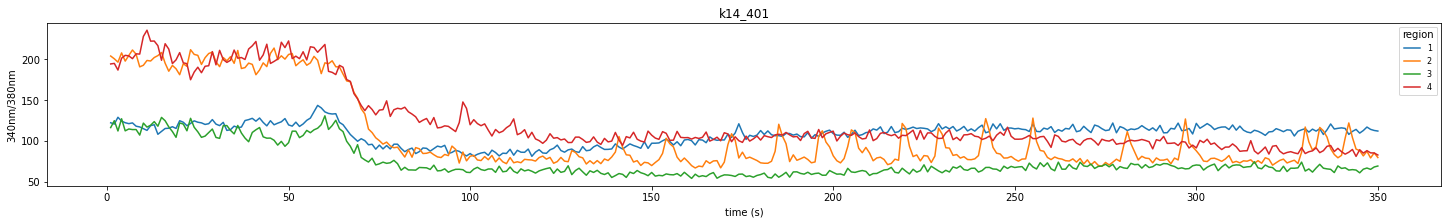

Label(value='Stimulation zone 1:')

IntRangeSlider(value=(1, 350), continuous_update=False, description=' ', layout=Layout(width='1460px'), max=35…

In [77]:
%matplotlib inline

# Global Variables
out = widgets.Output()
total_zones = []
labels = []
plt.close('all') # Frees up memory


if link_zones == True:
    dt = int(tmax-tmin) / int(num_stim_widget.value)
    # Create label widgets
    label_widgets = [widgets.Label("Stimulation zone " + str(j+1) + ":") 
                     for j in range(0,int(num_stim_widget.value))]
    stim_zones = [widgets.IntRangeSlider(value=(tmin + (j*dt), tmin + (j+1)*dt),
                                             min=tmin, max=tmax,
                                             step=1, disabled=False, continuous_update=False, 
                                             orientation='horizontal', description=" ", readout=True,
                                             readout_format='d', layout={'width':'1460px'},
                                             style={'description_width':'95px'})
                      for j in range(0,int(num_stim_widget.value))]
for i in range(0,len(selected_files)):
    if link_zones == False:
        # Local Variables
        tmin = np.min(A0s[i][0]) # Start time
        tmax = np.max(A0s[i][0]) # Finish time
        dt = int(tmax-tmin) / int(num_stim_widgets[i].value)
        # Create label widgets
        label_widgets = [widgets.Label("Stimulation zone " + str(j+1) + ":") 
                         for j in range(0,int(num_stim_widgets[i].value))]
        labels.append(label_widgets) # Adding labels to total lsit so they can be accessed later
        stim_zones = [widgets.IntRangeSlider(value=(tmin + (j*dt), tmin + (j+1)*dt),
                                             min=tmin, max=tmax,
                                             step=1, disabled=False, continuous_update=False, 
                                             orientation='horizontal', description=" ", readout=True,
                                             readout_format='d', layout={'width':'1460px'},
                                             style={'description_width':'95px'})
                      for j in range(0,int(num_stim_widgets[i].value))]
        total_zones.append(stim_zones) # Adding widgets to total list so they can be accessed later
    fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(20,3), constrained_layout=True)
    ax.set_title(selected_files[i])
    ax.set(ylabel="340nm/380nm")
    ax.set(xlabel="time (s)")
    ax.plot(A0s[i][0],np.transpose(A0s[i][full_cols[i]]))
    if len(full_cols[i]) < 11:
        ax.legend(full_cols[i], title='region', fontsize=8)
    plt.show()
    plt.close() # Frees up memory
    # Making separate plots to save as representative trace pdfs
    fig, ax = plt.subplots(ncols=1,nrows=1, figsize=(15,3), constrained_layout=True)
    ax.set_title(selected_files[i])
    ax.set(ylabel="340nm/380nm")
    ax.set(xlabel="time (s)")
    ax.plot(A0s[i][0],np.transpose(A0s[i][full_cols[i]]))
    ax.set_ylim([0,2.0]) # Manually setting y-axis so same for all plots
    if len(full_cols[i]) < 11:
        ax.legend(full_cols[i], title='region', fontsize=8)
    plt.savefig(results_dirs[i] + "/full_trace" + ".pdf") # Save figure as pdf
    plt.savefig(results_dirs[i] + "/full_trace" + ".png") # Save figure as png
    plt.close() # Frees up memory
    if link_zones == False:
        for j in range(0,len(total_zones[i])):
            display(labels[i][j])
            display(total_zones[i][j]) # Display each zone widget for each particular file
if link_zones == True:
    for j in range(0,int(num_stim_widget.value)):
        display(label_widgets[j])
        display(stim_zones[j])
    

# Plot data and stimulation time zones
- Stimulation zones are marked with a white background color

In [78]:
%matplotlib inline

# If stimulation zones are same, duplicated signal stimulation zone entry for all files
if link_zones == True:
    for i in range(0,len(selected_files)):
        temp_zones = []
        for j in range(0,int(num_stim_widget.value)):
            temp_zones.append(stim_zones[j])
        total_zones.append(temp_zones)

# Global variables
zn = np.array(total_zones, dtype=object)

automatic_baselines = []
starting_baselines = []
# Filling arrays with initial values
for i in range(0,len(selected_files)):
    automatic_baselines.append(False)
    starting_baselines.append(False)
plt.close('all')
if link_zones == False:
    automatic_baseline_widgets = [widgets.Checkbox(value=False, 
                                                 description="Check this box to have automatic baselines for " + selected_files[i],
                                                 disabled=False,layout={'width':'650px'}, style={'description_width':'600px'},
                                                 indent=False,) for i in range(0,len(selected_files))]
    starting_baseline_widgets = [widgets.Checkbox(value=False,
                                                description="Check this box to have starting baseline for " + selected_files[i],
                                                disabled=False,layout={'width':'650px'}, style={'description_width':'600px'},
                                                indent=False) for i in range(0,len(selected_files))]
    out = widgets.Output()

for i in range(0,len(selected_files)):
    # Local variables
    dmin = np.amin(A0s[i][full_cols[i]]) # Minimum Y-value
    dmax = np.amax(A0s[i][full_cols[i]]) # Maximum Y-value
    if link_zones == False:
        baselines_widg = widgets.VBox(children=[out,automatic_baseline_widgets[i],starting_baseline_widgets[i]])
        display(baselines_widg)
    else:
        baselines_widg = widgets.VBox(children=[out])
        display(baselines_widg)
    with out:
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(13,3), constrained_layout=True)
        ax.set_title(str(len(zn[i])) + "x stimulation time zone ranges for " + selected_files[i])
        ax.set(ylabel="340/380nm")
        ax.set(xlabel="time (s)")
        ax.set_facecolor('0.8') # Grey out plot areas not in any zone
        for z in zn[i]:
            ax.fill((z.value[0],z.value[1],z.value[1],z.value[0]),(dmin,dmin,dmax,dmax),'1.0')
            ax.plot([z.value[0],z.value[0]],[dmin,dmax],color='0.8') # Grey vertical lines in case zones overlap
            ax.plot([z.value[1],z.value[1]],[dmin,dmax],color='0.8')
        ax.plot(A0s[i][0],np.transpose(A0s[i][full_cols[i]]))
        if len(full_cols[i]) < 11:
            ax.legend(full_cols[i], title='region', fontsize=8)
        plt.show()
        plt.close() # Frees up memory
    out = widgets.Output()
if link_zones == True:
    automatic_baseline_widget = widgets.Checkbox(value=False, 
                                                 description="Check this box to have automatic baselines for all",
                                                 disabled=False,
                                                 layout={'width':'650px'}, style={'description_width':'600px'},
                                                 indent=False)
    starting_baseline_widget = widgets.Checkbox(value=False,
                                                description="Check this box to have starting baseline for all",
                                                disabled=False,
                                                layout={'width':'650px'}, style={'description_width':'600px'},
                                                indent=False)
    def f(w1,w2):
        global automatic_baselines, starting_baselines
    display(widgets.interactive(f, w1=automatic_baseline_widget, w2=starting_baseline_widget))

interactive(children=(Checkbox(value=False, description='Check this box to have automatic baselines for all', …

# Peak counting and latency calculation settings

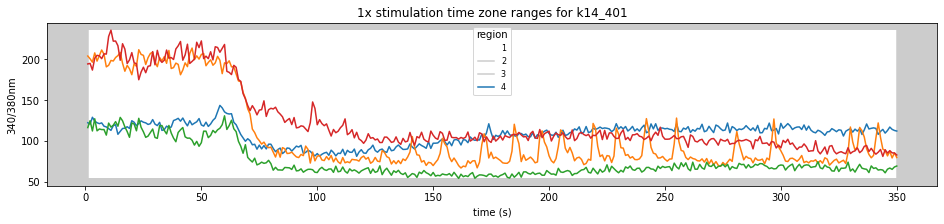

In [79]:
%matplotlib inline
# Global variables
pk_options = []
slope_types = []
num_stds = []
baselines = []
base_lengths = []
start_lengths = []
response_stds = []
# Reseting zn in case next code block is run, 
# and then this one is run again (prevents error)
zn = np.array(total_zones, dtype=object)

# Filling Global Variable arrays with initial values
for i in range(0,len(selected_files)):
    pk_options.append([0,0])
    slope_types.append(0)
    num_stds.append(0)
    baselines.append([0,0])
    base_lengths.append(0)
    start_lengths.append(0)
    response_stds.append(0)

# create sensitivity widgets
sensitivity_widgets = [widgets.Dropdown(
    options=[('low',(0.06,4)),('low-medium',(0.05,6)),('medium',(0.04,7)),('high-medium',(0.03,8)),('high',(0.02,9))],
    value=(0.04,7),
    description='Peak counting sensitivity:',
    disabled=False,
    layout={'width':'350px'}, style={'description_width':'180px'}
) for i in range(0,len(selected_files))]

# create type of slope calculation widgets
slope_widgets = [widgets.Dropdown(
    options = [('simple difference',(1)),('three-neighbour',(2)),('polynomial fit',(3)),('gaussian fit',(4))],
    value = 1,
    description='Slope calculation method:',
    disabled = False,
    layout={'width':'350px'}, style = {'description_width':'180px'}
) for i in range(0,len(selected_files))]

# create number of standard deviations widgets
std_widgets = [widgets.Dropdown(
    options = [('1',(1)),('2',(2)),('3',(3)),('4',(4)),('5',(5)),('6',(6)),('7',(7))],
    value = 2,
    description = 'Threshold standard deviations:',
    disabled = False,
    layout={'width':'260px'}, style = {'description_width':'200px'}
) for i in range(0,len(selected_files))]

# create number of standard deviations for response threshold widgets
response_std_widgets = [widgets.Dropdown(
    options = [('1',(1)),('2',(2)),('3',(3)),('4',(4)),('5',(5)),('6',(6)),('7',(7))],
    value = 4,
    description = 'Response % standard deviations:',
    disabled = False,
    layout={'width':'260px'}, style = {'description_width':'200px'}
) for i in range(0,len(selected_files))]

# create baseline zone widgets
baseline_widgets = [widgets.IntRangeSlider(
    value=(tmin,tmax), min=tmin, max=tmax, step=1,
    description="Baseline unstimulated time"+' (s)',
    disabled=False, continuous_update=False, orientation='horizontal',
    readout=True, readout_format='d',
    layout={'width':'900px'}, style={'description_width':'200px'}
) for i in range(0,len(selected_files))]

# create automatic baseline length widgets
baseline_length_widgets = [widgets.IntSlider(
    value=10,
    min=2,
    max=20,
    step=1,
    description='Length of Automatic Baselines (in seconds):',
    layout={'width':'450px'}, style = {'description_width':'250px'},
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d'
) for i in range(0,len(selected_files))]

# create starting baseline length widgets
start_length_widgets = [widgets.IntSlider(
    value=10,
    min=2,
    max=20,
    step=1,
    description='Length of Starting Baseline (in seconds):',
    layout={'width':'450px'}, style = {'description_width':'250px'},
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d'
) for i in range(0,len(selected_files))]

# Displaying widgets based on previous widget selections
if link_zones == True:
    # Updating starting_baselines and automatic_baselines arrays
    for i in range(0,len(selected_files)):
        starting_baselines[i] = starting_baseline_widget.value
        automatic_baselines[i] = automatic_baseline_widget.value
    plt.clf()
    plt.close('all')
    for i in range(0,len(selected_files)):
            dmin = np.amin(A0s[i][full_cols[i]]) # Minimum Y-value
            dmax = np.amax(A0s[i][full_cols[i]]) # Maximum Y-value
            fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(13,3), constrained_layout=True)
            ax.set_title(str(len(zn[i])) + "x stimulation time zone ranges for " + selected_files[i])
            ax.set(ylabel="340/380nm")
            ax.set(xlabel="time (s)")
            ax.set_facecolor('0.8') # Grey out plot areas not in any zone
            for z in zn[i]:
                ax.fill((z.value[0],z.value[1],z.value[1],z.value[0]),(dmin,dmin,dmax,dmax),'1.0')
                ax.plot([z.value[0],z.value[0]],[dmin,dmax],color='0.8') # Grey vertical lines in case zones overlap
                ax.plot([z.value[1],z.value[1]],[dmin,dmax],color='0.8')
            ax.plot(A0s[i][0],np.transpose(A0s[i][full_cols[i]]))
            if len(full_cols[i]) < 11:
                ax.legend(full_cols[i], title='region', fontsize=8)
            plt.show()
            plt.clf()
            plt.close() # Frees up memory
    if automatic_baselines[0] == True and starting_baselines[0] == True:
        options_widg = widgets.VBox(children=[sensitivity_widgets[0],slope_widgets[0],std_widgets[0],response_std_widgets[0],
                                              baseline_length_widgets[0],start_length_widgets[0]])
        display(options_widg)
    elif automatic_baselines[0] == True:
        options_widg = widgets.VBox(children=[sensitivity_widgets[0],slope_widgets[0],std_widgets[0],
                                              response_std_widgets[0],baseline_length_widgets[0]])
        display(options_widg)
    elif starting_baselines[0] == True:
        options_widg = widgets.VBox(children=[sensitivity_widgets[0],slope_widgets[0],std_widgets[0],
                                              response_std_widgets[0],baseline_widgets[0],start_length_widgets[0]])
        display(options_widg)
    else:
        options_widg = widgets.VBox(children=[sensitivity_widgets[0],slope_widgets[0],std_widgets[0],
                                              response_std_widgets[0],baseline_widgets[0]])
        display(options_widg)

else:
    # Updating starting_baselines and automatic_baselines arrays
    for i in range(0,len(selected_files)):
        starting_baselines[i] = starting_baseline_widgets[i].value
        automatic_baselines[i] = automatic_baseline_widgets[i].value
    out = widgets.Output()
    plt.clf()
    plt.close('all')
    for i in range(0,len(selected_files)):
        # Local variables
        dmin = np.amin(A0s[i][full_cols[i]]) # Minimum Y-value
        dmax = np.amax(A0s[i][full_cols[i]]) # Maximum Y-value
        
        if automatic_baselines[i] == True and starting_baselines[i] == True:
            options_widg = widgets.VBox(children=[out,sensitivity_widgets[i],slope_widgets[i],std_widgets[i],
                                                  response_std_widgets[i],baseline_length_widgets[i],start_length_widgets[i]])
            display(options_widg)
        elif automatic_baselines[i] == True:
            options_widg = widgets.VBox(children=[out,sensitivity_widgets[i],slope_widgets[i],std_widgets[i],
                                                  response_std_widgets[i],baseline_length_widgets[i]])
            display(options_widg)
        elif starting_baselines[i] == True:
            options_widg = widgets.VBox(children=[out,sensitivity_widgets[i],slope_widgets[i],std_widgets[i],
                                                  response_std_widgets[i],baseline_widgets[i],start_length_widgets[i]])
            display(options_widg)
        else:
            options_widg = widgets.VBox(children=[out,sensitivity_widgets[i],slope_widgets[i],
                                                  response_std_widgets[i],std_widgets[i],baseline_widgets[i]])
            display(options_widg)
        with out:
            fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(13,3), constrained_layout=True)
            ax.set_title(str(len(zn[i])) + "x stimulation time zone ranges for " + selected_files[i])
            ax.set(ylabel="340/380nm")
            ax.set(xlabel="time (s)")
            ax.set_facecolor('0.8') # Grey out plot areas not in any zone
            for z in zn[i]:
                ax.fill((z.value[0],z.value[1],z.value[1],z.value[0]),(dmin,dmin,dmax,dmax),'1.0')
                ax.plot([z.value[0],z.value[0]],[dmin,dmax],color='0.8') # Grey vertical lines in case zones overlap
                ax.plot([z.value[1],z.value[1]],[dmin,dmax],color='0.8')
            ax.plot(A0s[i][0],np.transpose(A0s[i][full_cols[i]]))
            if len(full_cols[i]) < 11:
                ax.legend(full_cols[i], title='region', fontsize=8)
            plt.show()
            plt.close() # Frees up memory
        out = widgets.Output()

# Plot peaks and calculate latencies by region
- Peak points are marked with black color
- unstimulated time baseline and threshold is marked with light grey color
- latency response start points are marked with red color

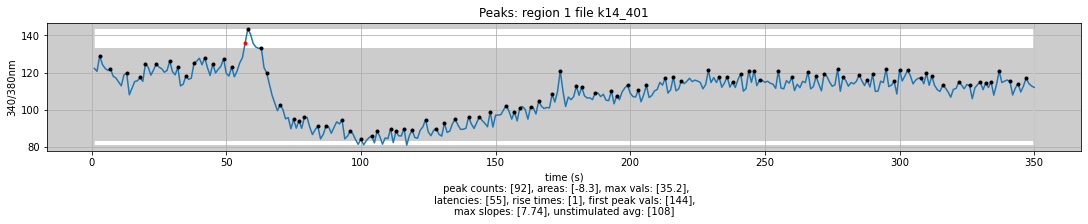

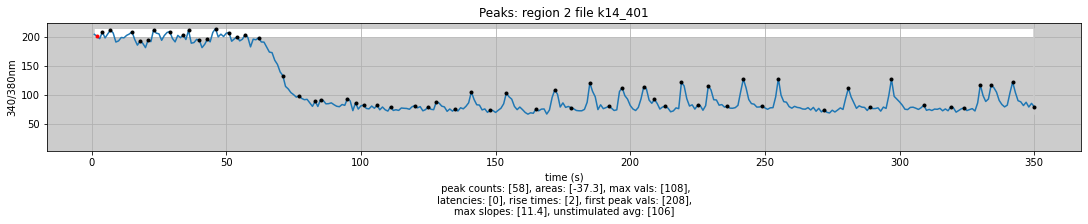

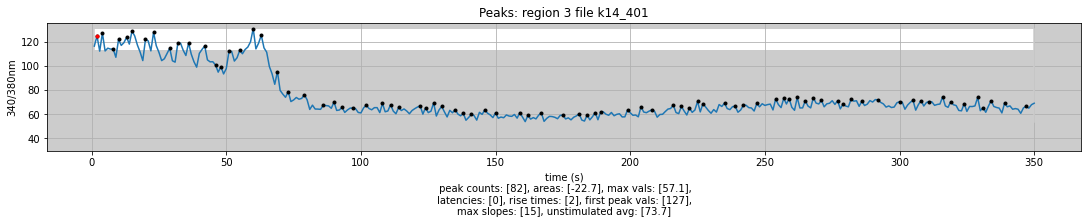

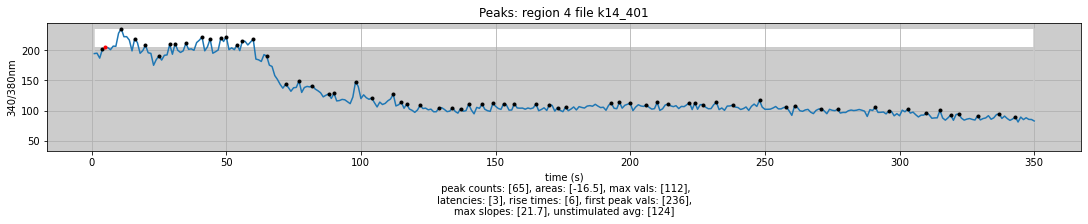

In [80]:
%matplotlib inline
def poly(x, a, b, c):
    return a * x + b * x**2 + c
def gauss(x, a, x0, sigma, y0):
    return y0 + (a * np.exp(-(x-x0)**2/(2*sigma**2)))
# Setting array values to input value if stimulation zones are same
if link_zones == True:
    for i in range(0,len(selected_files)):
        pk_options[i] = sensitivity_widgets[0].value
        slope_types[i] = slope_widgets[0].value
        num_stds[i] = std_widgets[0].value
        response_stds[i] = response_std_widgets[0].value
        if automatic_baselines[i] == False:
            baselines[i] = baseline_widgets[0].value
        if automatic_baselines[i] == True:
            base_lengths[i] = baseline_length_widgets[0].value
        if starting_baselines[i] == True:
            start_lengths[i] = start_length_widgets[0].value
if link_zones == False:
    for i in range(0,len(selected_files)):
        pk_options[i] = sensitivity_widgets[i].value
        slope_types[i] = slope_widgets[i].value
        num_stds[i] = std_widgets[i].value
        response_stds[i] = response_std_widgets[i].value
        if automatic_baselines[i] == False:
            baselines[i] = baseline_widgets[i].value
        if automatic_baselines[i] == True:
            base_lengths[i] = baseline_length_widgets[i].value
        if starting_baselines[i] == True:
            start_lengths[i] = start_length_widgets[i].value          
# Looping through each file selected
for i in range(0,len(selected_files)):
    # Local Variables
    zn = np.array(total_zones[i])
    tmin = np.min(A0s[i][0]) # Start time
    tmax = np.max(A0s[i][0]) # Finish time
    dmin = np.amin(A0s[i][full_cols[i]]) # Minimum Y-value
    dmax = np.amax(A0s[i][full_cols[i]]) # Maximum Y-value
    
    cts = []         # Peak counts            per zone, per region
    idx_fpks = []    # First peak indices          "        "
    idx_lsts = []    # Latency start indices       "        "
    latencies = []   # Latencies                   "        "
    rise_times = []  # Rise times                  "        "
    max_slopes = []  # Maximum slopes              "        "
    zone_areas = []  # Area under curve            "        "
    max_vals = []    # Maximum values              "        "
    unstim_avg = []  # Unstimulated average        "        "
    responding = []  # Whether max is over response threshold "    "
    starting_base = np.zeros_like(full_cols[i], dtype = float) # Starting unstimulated average "    "
    X0 = A0s[i][0]
    sr = 6.0 # Desired sample rate
    csr = (len(X0) - 1) / (tmax-tmin) # Current sample rate
    p = int((sr / csr) * len(X0)) # New number of points
    
    ##### Adjustment for different data sources ####
    if (csr < 1.0):
        filter_factor = 0.05
        prominence_factor = 3.0
    else:
        filter_factor = 1.0
        prominence_factor = 1.0
    ################################################
    
    # Delete any previous results
    for f in glob.glob(results_dirs[i] + "/.csv"): os.remove(f)
    for f in glob.glob(results_dirs[i] + "/.pdf"): os.remove(f)
    for f in glob.glob(results_dirs[i] + "/.png"): os.remove(f)
    plt.close('all') # Frees up memory
    for col in full_cols[i]: # For each region...
        if automatic_baselines[i] == True:
            baseline_avgs = []
        dmin = np.amin(A0s[i][col])
        dmax = np.amax(A0s[i][col])        
                
        Y0 = A0s[i][col]
        Y1 = (Y0 - dmin) / (dmax - dmin) # Data axis, normalized to range(0, 1.0)
        
        # Resample
        f = interp1d(X0, Y1, kind='cubic') # Define the resampling function
        X = np.linspace(tmin, tmax, p+1, endpoint=True) # Define the new time steps
        Y = f(X) # Resample the original signal
        
        # Apply high-pass filter to eliminate the stimulation "bump" in the data
        sos = signal.butter(3, 0.1*filter_factor, btype="highpass", fs=sr, output='sos')
        Yf = signal.sosfiltfilt(sos,Y) # Zero phase shift filter
        
        # Apply low-pass filter to smooth out higher frequencies in the data
        sos = signal.butter(pk_options[i][1], 2.0*filter_factor, btype='lowpass', fs=sr, output='sos')
        Yf = signal.sosfiltfilt(sos,Yf) # Zero phase shift filter
        
        # Find all the peaks
        pks,_ = signal.find_peaks(Yf,prominence=pk_options[i][0]*prominence_factor) # Find indices of peaks in the resampled, filtered data
        pidx = np.around((X0.shape[0]-1)*pks/p).astype(int) # Convert to indices in the original data
        pts = [A0s[i][0][pidx], A0s[i][col][pidx]]
        
        # Intitialize the region plot
        fix, ax = plt.subplots(ncols=1, nrows =1, figsize=(15,3), constrained_layout=True)
        ax.grid(visible=True)
        if included_widgets[i].value == True and col == max(full_cols[i]):
            ax.set_title("Peaks: Average file " + selected_files[i])
        else:
            ax.set_title("Peaks: region " + str(col) + " file " + selected_files[i])
        ax.set(ylabel="340/380nm")
        
        # Grey out plot areas not in any zone
        ax.set_facecolor('0.8')
        for z in zn:
            ax.fill((z.value[0],z.value[1],z.value[1],z.value[0]),(dmin,dmin,dmax,dmax),'1.0')
            ax.plot([z.value[0],z.value[0]],[dmin,dmax],color='0.8') # Grey vertical lines in case zones overlap
            ax.plot([z.value[1],z.value[1]],[dmin,dmax],color='0.8')
        # Plot baseline region marking
        # Analyze "noise" in the baseline region (for latency calculation)
        if automatic_baselines[i] == False:
            signal_avg = np.mean(A0s[i][col][np.logical_and(A0s[i][0] > baselines[i][0], A0s[i][0] < baselines[i][1])]) # Dc component of noisy signal
            unstim_avg.append(signal_avg)
            noise = A0s[i][col][np.logical_and(A0s[i][0] > baselines[i][0], A0s[i][0] < baselines[i][1])] - signal_avg # Ac    "      "
            thresh = signal_avg + (num_stds[i] * np.std(noise)) # Latency threshold value
            response_thresh = signal_avg + (response_stds[i] * np.std(noise)) # Response threshold value
            mthresh = signal_avg - (num_stds[i] * np.std(noise)) # Mirror threshold value around signal_avg
            ax.fill((baselines[i][0],baselines[i][1],baselines[i][1],baselines[i][0]),(mthresh,mthresh,thresh,thresh),'0.8') # Mark threshold region on plot
            # Find all the peaks
            pks,_ = signal.find_peaks(Yf,prominence=pk_options[i][0]*prominence_factor) # Find indices of peaks in the resampled, filtered data
            pidx = np.around((X0.shape[0]-1)*pks/p).astype(int) # Convert to indices in the original data
            point_thresh = signal_avg + ((num_stds[i] + 2) * np.std(noise)) # Threshold for points, with stds + 2 than that of latency thresh
            pts = [A0s[i][0][pidx], A0s[i][col][pidx]]
            c = [] # Peak counts per zone
            for z in zn: # Get peak counts in each zone
                idx = pidx[(pidx >= np.where(A0s[i][0] > z.value[0])[0][0]) & (pidx <= np.where(A0s[i][0] < z.value[1])[0][-1])]
                c.append(len(idx))
            cts.append(c)
        if automatic_baselines[i] == True:
            # Find all the peaks
            pks,_ = signal.find_peaks(Yf,prominence=pk_options[i][0]*prominence_factor) # Find indices of peaks in the resampled, filtered data
            pidx = np.around((X0.shape[0]-1)*pks/p).astype(int) # Convert to indices in the original data
            for z in zn:
                baseline = [] # Automatic baseline values
                baseline.append(z.value[0] - (base_lengths[i] + 1))
                baseline.append(z.value[0] - 1)
                signal_avg = np.mean(A0s[i][col][np.logical_and(A0s[i][0] > baseline[0], A0s[i][0] < baseline[1])])  # Dc component of noisy signal
                noise = A0s[i][col][np.logical_and(A0s[i][0] > baseline[0], A0s[i][0] < baseline[1])] - signal_avg   # Ac    "          "    
                point_thresh = signal_avg + ((num_stds[i] + 2) * np.std(noise)) # Threshold for points, with stds + 2 than that of latency thresh
                pts = [A0s[i][0][pidx], A0s[i][col][pidx]]
            c = [] # Peak counts per zone
            for z in zn: # Get peak counts in each zone
                idx = pidx[(pidx >= np.where(A0s[i][0] > z.value[0])[0][0]) & (pidx <= np.where(A0s[i][0] < z.value[1])[0][-1])]
                c.append(len(idx))
            cts.append(c)
            
        # Plot data and peaks
        ax.plot(A0s[i][0],A0s[i][col]) # Plot data for this region
        ax.plot(A0s[i][0,pidx],A0s[i][col,pidx],'k.') # Plot the peak locations
        
        # Setting starting baseline values
        if starting_baselines[i] == True:
            start_avg = np.mean(A0s[i][col][np.logical_and(A0s[i][0]>(A0s[i][0][0]), A0s[i][0] < (A0s[i][0][0] + start_lengths[i]))])
            starting_base[np.where(full_cols[i] == col)] = start_avg
        
        # Find first peak, latency start point, latency, max slope and area under curve for every zone in this region
        # Local variables
        idx_fpk = [] # First peak  indices, for this region
        idx_lst = [] # Latency start  "         "
        lats = [] # Latencies         per zone, for this region
        riss = [] # Rise times           "            "
        slps = [] # Maximum slopes       "            "
        zars = [] # Area under curve     "            "
        maxs = [] # Maximum values       "            "
        resp = [] # Whether max is over response threshold   "           "
        
        for z in zn:
            plot_curve = True
            if automatic_baselines[i] == True:
                baseline = [] # Automatic baseline values
                baseline.append(z.value[0] - (base_lengths[i] + 1))
                baseline.append(z.value[0] - 1)
                signal_avg = np.mean(A0s[i][col][np.logical_and(A0s[i][0] > baseline[0], A0s[i][0] < baseline[1])])  # Dc component of noisy signal
                baseline_avgs.append(signal_avg)
                noise = A0s[i][col][np.logical_and(A0s[i][0] > baseline[0], A0s[i][0] < baseline[1])] - signal_avg   # Ac    "          "
                thresh = signal_avg + (num_stds[i] * np.std(noise))                                          # Latency threshold value
                response_thresh = signal_avg + (response_stds[i] * np.std(noise))                           # Response threshold value
                mthresh = signal_avg - (num_stds[i] * np.std(noise))                                       # Mirror threshold value around signal_avg
            zidx = np.where(np.logical_and(A0s[i][0] > z.value[0], A0s[i][0] < z.value[1]))[0]                               # All indices within zone
            pzidx = pidx[(pidx >= np.where(A0s[i][0] > z.value[0])[0][0]) & (pidx <= np.where(A0s[i][0] < z.value[1])[0][-1])] # Peak "       "
            idxf = -1  # First peak index for this zone
            idxl = -1  # Latency start index for this zone
            if len(pidx) > 0: # If any peaks in the zone
                for j in zidx: # Find latency start point in this zone
                    if A0s[i][col,j] >= thresh:  # If above the threshold
                        ax.plot(A0s[i][0,j],A0s[i][col,j],'r.') # Plot the latency start location
                        idxl = j
                        break
                for j in pzidx:
                    if A0s[i][0,j] > A0s[i][0,idxl]: # First peak after latency point
                        idxf = j                     # Save
                        break
            idx_fpk.append(idxf)                     # Save first peak
            idx_lst.append(idxl)                     # Save latency start
            # Calculating if over response threshold
            if len(np.argwhere(A0s[i][col,zidx]>= response_thresh)) > 2:
                resp.append(True)
            else:
                resp.append(False)
            
            lat = 0
            ris = 0
            slp = 0
            if (idxf != -1) and (idxl != -1):
                lat = A0s[i][0,idxl] - A0s[i][0,zidx[0]] # Save latency time
                ris = A0s[i][0,idxf] - A0s[i][0,idxl]     # Save rise time
                x_vals = A0s[i][0,idxl:idxf+1]
                y_vals = A0s[i][col,idxl:idxf+1]
                if slope_types[i] == 1:  # Simple difference calculations
                    for j in range(len(x_vals)-1):
                        sl = (y_vals[j+1] - y_vals[j]) / (x_vals[j+1] - x_vals[j])
                        if sl > slp:
                            slp = sl
                if slope_types[i] == 2:  # Three neighbor numerical calculations
                    if len(x_vals) > 5:
                        for j in range(3, len(x_vals) - 3):
                            sls = []
                            for k in range(1,4):
                                y1 = y_vals[j - k]
                                y2 = y_vals[j + k]
                                x1 = x_vals[j - k]
                                x2 = x_vals[j + k]
                                sls.append((y2-y1)/(x2-x1))
                            sl = np.mean(sls)
                            if sl > slp:
                                slp = sl
                    else:
                        print("For the following graph, not enough data points for Three Neighbor Numerical, instead using Simple Difference")
                        for j in range(len(x_vals)-1):
                            sl = (y_vals[j+1] - y_vals[j]) / (x_vals[j+1] - x_vals[j])
                            if sl > slp:
                                slp = sl
                if slope_types[i] == 3:   # Polynomial fit calculations
                    if len(x_vals) > 3:
                        popt, pcov = curve_fit(poly, x_vals, y_vals)
                        fitted_y_vals = poly(x_vals, *popt)
                        ax.plot(x_vals,fitted_y_vals,'r')
                        if len(fitted_y_vals) > 3:
                            for j in range(1, len(fitted_y_vals)):
                                sl = (fitted_y_vals[j] - fitted_y_vals[j - 1]) / (x_vals[j] - x_vals[j-1])
                                if sl > slp:
                                    slp = sl
                    else:
                        print("For the following graph, not enough data points for Polynomial Fit, instead using Simple Difference")
                        for j in range(len(x_vals)-1):
                            sl = (y_vals[j+1] - y_vals[j]) / (x_vals[j+1] - x_vals[j])
                            if sl > slp:
                                slp = sl
                if slope_types[i] == 4:   # Gaussian fit calculations
                    x_vals = A0s[i][0,idxl:idxf+1+len(x_vals)]  # Extend selection of values to be symetrical around the peak
                    y_vals = A0s[i][col,idxl:idxf+1+len(y_vals)]
                    if len(x_vals) > 6:
                        mean = sum(x_vals * y_vals) / sum(y_vals)
                        sigma = math.sqrt(sum(y_vals * (x_vals - mean)**2) / sum(y_vals))
                        y0 = thresh
                        with warnings.catch_warnings():
                            warnings.simplefilter("error", OptimizeWarning)
                            try:
                                popt, pcov = curve_fit(gauss, x_vals, y_vals, p0=[max(y_vals),mean,sigma,y0], maxfev = 5000)
                            except RuntimeError:
                                print("A Gaussian Curve could not be calculated for the following graph, instead using Simple Difference")
                                plot_curve = False # Do not plot curve if cant be calculated
                                for j in range(len(x_vals)-1):
                                    sl = (y_vals[j+1] - y_vals[j]) / (x_vals[j+1] - x_vals[j])
                                    if sl > slp:
                                        slp = sl
                            except OptimizeWarning:
                                print("A Gaussian Curve could not be calculated for the following graph, instead using Simple Difference")
                                plot_curve = False # Do not plot curve if cant be calculated
                                for j in range(len(x_vals)-1):
                                    sl = (y_vals[j+1] - y_vals[j]) / (x_vals[j+1] - x_vals[j])
                                    if sl > slp:
                                        slp = sl
                        if plot_curve == True:
                            fitted_y_vals = gauss(x_vals, *popt)
                            ax.plot(x_vals,fitted_y_vals,'r')
                            peak_index = np.where(fitted_y_vals == np.max(fitted_y_vals))  # Find where peak of gaussian curve
                            for j in range(1, int(peak_index[0][0])):
                                sl = (fitted_y_vals[j] - fitted_y_vals[j - 1]) / (x_vals[j] - x_vals[j - 1])
                                if sl > slp:
                                    slp = sl
                    else:
                        print("For the following graph, not enough data points for Gaussian Curve, instead using Simple Difference")
                        for j in range(len(x_vals)-1):
                            sl = (y_vals[j+1] - y_vals[j]) / (x_vals[j+1] - x_vals[j])
                            if sl > slp:
                                slp = sl

            lats.append(lat)
            riss.append(ris)
            slps.append(slp)
            maxs.append(np.amax(A0s[i][col,zidx]) - signal_avg)
            if (idxf != -1) and (idxl != -1):
                zars.append(np.trapz(A0s[i][col,zidx] - signal_avg, A0s[i][0,zidx]))  # Calculate and save area under curve
            else: # If no latency point, zone area is zero 
                zars.append(0)
        
        # Finalize and save the region plot
        xlab = "time (s)\n peak counts: " + str(c)
        xlab += (", areas: ["+', '.join(['%.3g']*len(zars))+"]") % tuple(zars)
        xlab += (", max vals: ["+', '.join(['%.3g']*len(maxs))+"]") % tuple(maxs)
        xlab += (",\nlatencies: ["+', '.join(['%.3g']*len(lats))+"]") % tuple(lats)
        xlab += (", rise times: ["+', '.join(['%.3g']*len(riss))+"]") % tuple(riss)
        xlab += (", first peak vals: ["+', '.join(['%.3g']*len(idx_fpk))+"]") % tuple([A0s[i][col,x] if x!=-1 else 0 for x in idx_fpk])
        xlab += (",\nmax slopes: ["+', '.join(['%.3g']*len(slps))+"]") % tuple(slps)
    
        if automatic_baselines[i] == True:
            xlab += (", unstimulated avg: [" + ', '.join(['%.3g']*len(baseline_avgs))+"]") % tuple(baseline_avgs)
        else:
            xlab += (", unstimulated avg: [" + f'''{signal_avg:.3g}'''+ "]")
    
        if starting_baselines[i] == True:
            xlab += (", starting unstimulated avg: [" + f'''{start_avg:.3g}'''+ "]")
        ax.set(xlabel=xlab)
        plt.savefig(results_dirs[i] + "/peaks_region_" + str(col) + ".pdf") # Save figure as pdf
        plt.show()
        plt.close() # Frees up memory
    
    
        idx_fpks.append(idx_fpk) # Save the first peaks across all regions
        idx_lsts.append(idx_lst) #  "       Latency starts     "
        latencies.append(lats)   #  "       Latencies          "
        rise_times.append(riss)  #  "       Rise times         "
        max_slopes.append(slps)  #  "       Maximum slopes     "
        zone_areas.append(zars)  #  "       Area under curve   "
        max_vals.append(maxs)    #  "       Maximum values     "
        responding.append(resp)  #  "       Whether max values are over response threshold   "
    
        if automatic_baselines[i] == True:
            unstim_avg.append(baseline_avgs)
        
        # Average standard deviation plotting
        if included_widgets[i].value == True and col == max(full_cols[i]):
            fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15,3), constrained_layout=True)
            ax.grid(visible=True)
            ax.set_title("Standard deviation of Average of " + selected_files[i])
            ax.set(ylabel="340/380nm")
            ax.set(xlabel="time (s)")
            ax.plot(A0s[i][0],A0s[i][col], label="Average")
            avg_X = A0s[i][0]
            avg = A0s[i][col]
            pre_std = A0s[i][1:col]
            std = pre_std.std(axis=0)
            ax.errorbar(avg_X[0::10],avg[0::10],std[0::10], linestyle='None',
                   marker='^', label="Standard Deviation") # Std plotting of every 10th point's std
            ax.legend(loc = 'best')
            plt.savefig(results_dirs[i] + "/std_average_" + ".pdf") # Save figure as pdf
            plt.show()
            plt.close()
    
        # Save peak points to CSV file
        with open(results_dirs[i] + "/all_peaks_region_" + str(col) + ".csv", "w", newline="") as file:
            writer = csv.writer(file)
            writer.writerow(("time","peak value"))
            for pk in pidx:
                r = (A0s[i][0,pk],A0s[i][col,pk])
                writer.writerow('{:.3g}'.format(x) for x in tuple(r))
                
    percent_responding = (np.sum(responding,axis=0) / len(full_cols[i])) * 100 # Calculating percentage of ROIS that respond in each zone

    # Save peak counts and optional latency summaries to CSV file
    if automatic_baselines[i] == False and starting_baselines[i] == False:
        with open (results_dirs[i] + "/total_data_by_zone.csv", 'w',newline="") as file:
            writer = csv.writer(file)
            writer.writerow(("region number", "peak counts", "first peak values", "areas", "maximum values", "latencies", "rise times", 
                             "maximum slopes", "unstimulated average", "responding percentage (by zone)"))
            for j in range(len(zone_areas[0])):
                writer.writerow((""))
                for k in range(len(full_cols[i])):
                    r = (full_cols[i][k], cts[k][j], A0s[i][full_cols[i][k],idx_fpks[k][j]] if idx_fpks[k][j]!=-1 else 0,
                         zone_areas[k][j], max_vals[k][j], latencies[k][j],
                         rise_times[k][j], max_slopes[k][j], unstim_avg[k], percent_responding[j])
                    writer.writerow('{:.3g}'.format(x) for x in tuple(r))
                
    elif automatic_baselines[i] == True and starting_baselines[i] == True:
        with open (results_dirs[i] + "/total_data_by_zone.csv", 'w',newline="") as file:
            writer = csv.writer(file)
            writer.writerow(("region number", "peak counts", "first peak values", "areas", "maximum values", "latencies", "rise times", 
                             "maximum slopes", "unstimulated average", "starting unstimulated average", "responding percentage (by zone)"))
            for j in range(len(zone_areas[0])):
                writer.writerow((""))
                for k in range(len(full_cols[i])):
                    r = (full_cols[i][k], cts[k][j], A0s[i][full_cols[i][k],idx_fpks[k][j]] if idx_fpks[k][j]!=-1 else 0,
                         zone_areas[k][j], max_vals[k][j], latencies[k][j],
                         rise_times[k][j], max_slopes[k][j], unstim_avg[k][j], starting_base[k], percent_responding[j])
                    writer.writerow('{:.3g}'.format(x) for x in tuple(r))
    elif automatic_baselines[i] == True and starting_baselines[i] == False:
        with open (results_dirs[i] + "/total_data_by_zone.csv", 'w',newline="") as file:
            writer = csv.writer(file)
            writer.writerow(("region number", "peak counts", "first peak values", "areas", "maximum values", "latencies", "rise times", 
                             "maximum slopes", "unstimulated average", "responding percentage (by zone)"))
            for j in range(len(zone_areas[0])):
                writer.writerow((""))
                for k in range(len(full_cols[i])):
                    r = (full_cols[i][k], cts[k][j], A0s[i][full_cols[i][k], idx_fpks[k][j]] if idx_fpks[k][j]!=-1 else 0,
                         zone_areas[k][j], max_vals[k][j], latencies[k][j], 
                         rise_times[k][j], max_slopes[k][j], unstim_avg[k][j], percent_responding[j])
                    writer.writerow('{:.3g}'.format(x) for x in tuple(r))
    else:
        with open (results_dirs[i] + "/total_data_by_zone.csv", 'w',newline="") as file:
            writer = csv.writer(file)
            writer.writerow(("region number", "peak counts", "first peak values", "areas", "maximum values", "latencies", "rise times", 
                             "maximum slopes", "unstimulated average", "starting unstimulated average", "responding percentage (by zone)"))
            for j in range(len(zone_areas[0])):
                writer.writerow((""))
                for k in range(len(full_cols[i])):
                    r = (full_cols[i][k], cts[k][j], A0s[i][full_cols[i][k], idx_fpks[k][j]] if idx_fpks[k][j]!=-1 else 0,
                         zone_areas[k][j], max_vals[k][j], latencies[k][j], 
                         rise_times[k][j], max_slopes[k][j], unstim_avg[k], starting_base[k], percent_responding[j])
                    writer.writerow('{:.3g}'.format(x) for x in tuple(r))

    # save standard deviation of average values to CSV file
    if included_widgets[i].value == True: # If avg column is included show standard deviation from avg
        with open(results_dirs[i] + "/std_average_" + ".csv", 'w',newline="") as file:
            writer = csv.writer(file)
            writer.writerow(("time(s)","average","standard deviation"))
            for x in range(len(A0s[i][0])):
                r = (avg_X[x], avg[x], std[x])
                writer.writerow('{:.3g}'.format(x) for x in tuple(r)) 